### read fasta files, score alignments

In [6]:
# FASTA importer function

# Define fasta_importer that takes a file path as a string and returns a dictionary of the FASTA data.
def fasta_importer(path: str) -> dict:

    # Create empty dictionary fasta_dict in which to store the file.
    fasta_dict = {}

    # Initiate the variable first_line to True, which will be set to False once the first line is read.
    first_line = True

    # Define the set valid_chars containing the permitted characters.
    valid_chars = ['A', 'C', 'G', 'T', '-']

    # Open the FASTA file.
    with open(path, 'r') as f:

        # Initiate while loop to read lines one at a time.
        while True:

            # Strip whitespace characters from the start and end of the line and save the string to the variable
            # line.
            line = f.readline().strip()

            # Check if the line starts with '>', in which case it is a header.
            if line.startswith('>'):

                # Add the previous header and complete sequence read before it to the dictionary fasta_dict.
                if not first_line:
                    fasta_dict[head] = seq

                # If the first line of the file is being read, do not add anything to the dictionary since
                # a sequence has not been read yet. Set first_line to False.
                else:
                    first_line = False
            
                # Assign the line to the variable head and set header_read to True.
                head = line
                header_read = True

            # If the line does not start with '>' it is a sequence.
            else:
                
                # Check that the sequence contains only valid characters.
                if sum(line.upper().count(c) for c in valid_chars) != len(line):
                    raise TypeError(f'Invalid characters detected in sequence "{head.split()[0][1:]}". '
                                    f'Program interrupted, please re-align sequences.')

                # Check if the previously read line was a header. If so, assign the current line to the
                # variable seq.
                if header_read:
                    seq = line.upper()

                # If the previously read line was a sequence, add the current line to the previous line to fix
                # sequences split by newline characters.
                else:
                    seq += line.upper()

                # Assign the variable header_read to False if the line read did not start with a '>'.
                header_read = False
        
            # Check if there are no more lines to read. Add the final head and seq pair to fasta_dict and break
            # the while loop.
            if not line:
                fasta_dict[head] = seq
                break

    return fasta_dict

In [109]:
# ----------------------
# Load data into memory.
# ----------------------

# Assign file path to path. 
path = 'exampledata/score.example.fna'
output_path = 'exampledata/output_fasta.txt'

fasta_dict = fasta_importer(path)

# --------------------------           
# Generate alignment scores.
# --------------------------

# Assign scores to variables.
match_score = 1
transition = -1 # a<->g or c<->t
transversion = -2 # other mutations
gap_penalty = -1
gap_match = 0 # this script assumes that if two sequences both have a gap in the same position, that
              # position of the parallel alignment adds 0 to the alignment score.

# Assign an empty list to the variable score_summary.
score_summary = ''

# Loop through the keys in the dictionary, calculating each possible pairwise score.
for i, key1 in enumerate(fasta_dict.keys()):
    for j, key2 in enumerate(fasta_dict.keys()):

        # Only calculate scores when i < j to ensure the same sequence does not get scored with itself or that
        # duplicate scores are reported.
        if i < j:

            # Assign sequences to variables and normalize case. Ensure that they are the same length, otherwise
            # interrupt the program.
            seq_a, seq_b = fasta_dict[key1], fasta_dict[key2]
            if len(seq_a) != len(seq_b):
                raise ValueError('sequences are not of the same length. program interrupted')

            # Initialize alignment scoring variables.
            identity = 0
            gaps = 0
            score = 0
            alignment_len = len(seq_a)

            # Zip the sequences to compare alignment at each position and loop through nucleotide by nucleotide.
            for a, b in zip(seq_a, seq_b):

                # Check if characters are identical.
                if a == b:

                    # If they represent matching nucleotides, update score and identity count.
                    if '-' not in a:
                        score += match_score
                        identity += 1
                        #print(a, b, match_score)

                        # IMPORTANT: matched gaps ('-') are ignored
                
                # If characters are not identical:
                else:

                    # Check if the unidentical characters represent a nucleotide transition and update the score.
                    if len({a, b} & {'A', 'G'}) == 2 or len({a, b} & {'C', 'T'}) == 2:
                        score += transition
                        #print(a, b, 'transition')

                    # The unidentical characters do not represent a nucleotide transition.
                    else:

                        # Check if the unidentical characters represent a gap and update the score and gap count.
                        if '-' in (a, b):
                            score += gap_penalty
                            gaps += 1
                            #print(a, b, 'gap')

                        # The last possible combinatinon of characters represents a transversion. Update the score.
                        else:
                            score += transversion
                            #print(a, b, 'transversion')

            # Add the score summary to the string score_summary.
            score_summary += (f'{key1[1:]}-{key2[1:]}: '
                              f'Identity: {identity}/{alignment_len} ({round(identity/alignment_len*100, 1)}%), '
                              f'Gaps: {gaps}/{alignment_len} ({round(gaps/alignment_len*100, 1)}%), '
                              f'Score={score}\n')


# ------------------
# Write output file.
# ------------------
with open(output_path, 'w') as f:
    f.write(score_summary)

### plotting

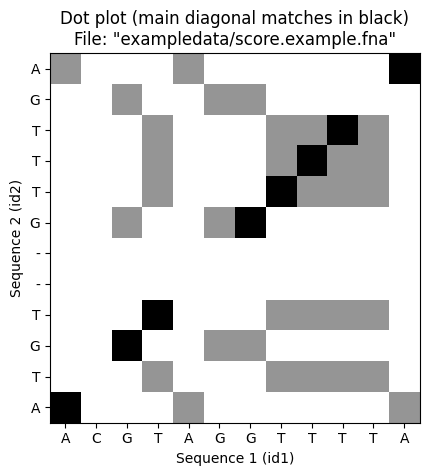

In [121]:
# Import FASTA file and convert it to a dictionary using function.
fasta_dict = fasta_importer(path)

# Loop through dictionary entries, plotting each sequence against every other sequence in the dictionary once.
for i, item1 in enumerate(fasta_dict.items()):
    for j, item2 in enumerate(fasta_dict.items()):

        # Assign variables head and seq for each dictionary to improve readability.
        head1 = item1[0]
        head2 = item2[0]
        seq1 = item1[1]
        seq2 = item2[1]

        # Ensure that a sequence does not get plotted against itself or that two sequences get plotted twice.
        if i < j:

            # Create the list im_list to store the data to be plotted.
            im_list = []

            # Loop through the bases of both sequences to evaluate if they represent on or off axis matches.
            # Start with the sequence that will be plotted on the y axis.

            # Since this program uses plt.imshow to show the data, the data must be constructed top-left down,
            # because the y axis on image data increases as it goes down.
            for l, base2 in enumerate(seq2[::-1]):

                # Assign a blank list to the variable row.
                row = []

                # Loop through the bases of the sequence plotted on the x axis, checking for matches.
                # Diagonal matches are encoded as 2, other matches are encoded as 1, non-matches are encoded as 0.
                for k, base1 in enumerate(seq1):

                    # Check if the bases are a match (matched gaps are not considered matches).
                    if base2 == base1 and base2 in 'ACGT':

                        # If the two indecies and 1 sum to the length of the sequence, the match is a diagonal
                        # match, since the sequence represented on the y axis is being read top down.
                        # Append the appropriate value to row.
                        if k + l + 1 == len(seq1):
                            row.append(2)

                        else:
                            row.append(1)
                            
                    # In the case of a non-match, append 0 to row. 
                    else:
                        row.append(0)

                # Append row to im_list once the entire row has been read.
                im_list.append(row)

            # Convert im_list to a numpy array so that it can be handled by plt.imshow.
            im = np.array(im_list)

            # Assign variables xticks and yticks to lists of each sequence, with sequence 2 reversed.
            xticks, yticks = list(seq1), list(seq2[::-1])

            # Assign fig and ax using a matplotlib figure and axes.
            fig, ax = plt.subplots()

            # Check the length of the sequences. If they are shorter than 30 bases, show each base and tick.
            # Otherwise, hide bases and ticks for readability.
            if len(seq1) < 30:
                plt.xticks(range(len(seq1)), xticks)
                plt.yticks(range(len(seq2)), yticks)
            else:
                plt.xticks([])
                plt.yticks([])

            # Set x and y axis labels with the protein ID from the header of the FASTA file, ensuring that only
            # the ID is read by splitting it into a list and printing only the first element without the '>'.
            id1 = head1.split()[0][1:]
            id2 = head2.split()[0][1:]
            
            ax.set_xlabel(f'Sequence 1 ({id1})')
            ax.set_ylabel(f'Sequence 2 ({id2})')

            # Set the plot title.
            plt.title(f'Dot plot (main diagonal matches in black)\nFile: "{path}"')

            # Show the plot.
            plt.imshow(im, cmap='Greys')
            
            # Save the plot.
            plt.savefig(f'{id1}_{id2}.png')